# Waterbody clustering

This notebook investigates the clustering of waterbodies based on their time series surface areas.

## Setup

### Load modules

In [845]:
from pathlib import Path

import numpy as np
import matplotlib.cm
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import scipy.spatial.distance
import scipy.ndimage
import sklearn.cluster
import sklearn.decomposition
from tqdm.notebook import tqdm

from fastdtw import fastdtw

### Load data

In [540]:
waterbody_shp_path = Path('/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/AusAllTime01-005HybridWaterbodies/AusWaterBodiesFINAL.shp')
waterbody_csv_path = Path('/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/timeseries_aus_uid/')
surface_area_threshold = 50

In [541]:
waterbody_shapes = gpd.read_file(waterbody_shp_path)

Choose an area of interest to focus on.

In [542]:
bbox = gpd.GeoDataFrame(geometry=gpd.points_from_xy((142.1246, 149.1300), (-37.0161, -34.2801)))  # Mildura -> Canberra, Seymour -> Griffith

In [543]:
bbox.crs = 'EPSG:4326'

In [544]:
x_min, y_min, x_max, y_max = bbox.to_crs('EPSG:3577').total_bounds

In [545]:
waterbody_shapes_ = waterbody_shapes.cx[x_min:x_max, y_min:y_max]

In [546]:
print(len(waterbody_shapes), 'waterbodies total')
print(len(waterbody_shapes_), 'in Mildura/Seymour/Canberra/Griffith area')

295906 waterbodies total
12535 in Mildura/Seymour/Canberra/Griffith area


In [547]:
waterbody_shapes = waterbody_shapes_

In [346]:
all_time_series = []
for i, shape in tqdm(waterbody_shapes.iterrows(), total=len(waterbody_shapes)):
    uid = shape.UID
    csv_path = waterbody_csv_path / uid[:4] / f'{uid}.csv'
    time_series = pd.read_csv(csv_path)
    # Relabel the third column to something consistent, and rename all columns to something
    # easier to access.
    time_series.rename(columns={
        'Observation Date': 'date',
        'Wet pixel percentage': 'pc_wet',
        time_series.columns[2]: 'px_wet',
        }, inplace=True)
    # Convert time strings into datetimes.
    time_series.date = pd.to_datetime(time_series.date)
    # Store the actual number of pixels too.
    n_pixels = shape.geometry.area // (25 ** 2)
    time_series.attrs['px_tot'] = n_pixels  # attrs is experimental.
    all_time_series.append(time_series)

In [347]:
waterbodies = waterbody_shapes.set_index('UID')

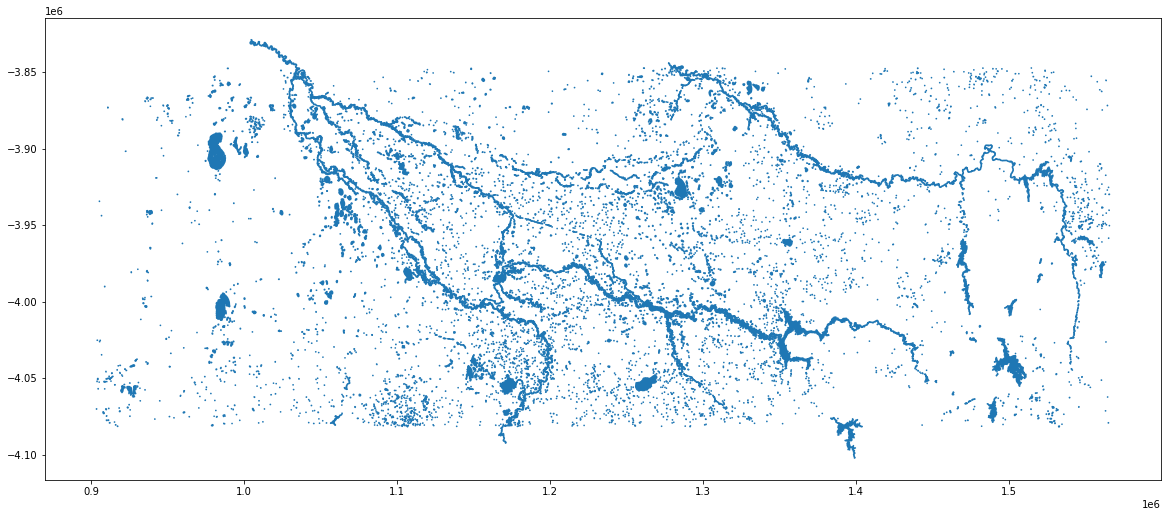

In [685]:
ax = plt.figure(figsize=(20, 10)).add_subplot(1, 1, 1)
waterbodies.buffer(500).plot(ax=ax)

In [348]:
assert len(all_time_series) == len(waterbody_shapes)

It would be useful to remove entries with NaN water levels (presumably cloud or similar).

In [349]:
all_time_series_ = []
for t in tqdm(all_time_series):
    nans = t.px_wet.isnull()
    t = t[~nans].reset_index(drop=True)
    all_time_series_.append(t)

In [350]:
all_time_series = all_time_series_

In [374]:
waterbodies['water_history'] = all_time_series

We need to define some kind of distance between two water level time series (henceforth "water histories"). These have different x values and lengths. A dilemma! One option is to interpolate so everything is the same length. We could also have some distance function that doesn't require the same x values. The former is simpler, and lets us use all our favourite distance measures, including all vector distances (e.g. cosine, Euclidean, Pearson correlation...) but requires assumptions on water behaviour. It also requires preprocessing the data to the same time steps, which will at minimum greatly increase the memory usage. The latter runs the risk of being slower. One option for the latter is dynamic time warping distance, but this requires a quadratic DP for each pair and can be pretty slow as a result, especially when there are many data points in each time series.

Let's start by interpolating to a common grid. How many elements should that grid have?

In [352]:
dates = set()
for waterbody in tqdm(waterbodies.water_history):
    dates |= set(waterbody.date.values)

In [353]:
print('average number of observations per waterbody:', waterbodies.water_history.map(lambda a: len(a)).mean())

average number of observations per waterbody: 664.7874750698046


In [354]:
print('unique dates:', len(dates))

unique dates: 11913


There are too many unique dates, so we might need to round a little.

In [355]:
dates = set()
for history in tqdm(waterbodies.water_history):
    dates |= set(history.date.dt.round('1d').values)

In [356]:
print('unique dates, day-rounded:', len(dates))

unique dates, day-rounded: 5261


For each water history we can add in all these dates.

In [357]:
dates = sorted(dates)

In [358]:
# First round every date and set date to be the index.
# Note that we also have to drop the timezone, which pandas assumes is UTC.
# If pandas did not assume it was UTC - maybe it assumed UTC+11 for example - then this would also do
# a conversion into UTC, which is probably not what we want.
for history in tqdm(waterbodies.water_history):
    history.date = history.date.dt.round('1d')
    history.set_index('date', drop=True, inplace=True)
    history.index = history.index.tz_convert(None)

In [359]:
dt_index = pd.DatetimeIndex(dates)

In [375]:
histories = []  # Storing reindexed dataframes back directly in waterbodies leads to some super bizarre behaviour where they are replaced entirely by nans.
# So, storing them in a list instead.
for i in tqdm(range(len(waterbodies))):
    # Merge duplicate dates into one.
    history = waterbodies.water_history[i].groupby('date').mean()
    # Then reindex with the full list of dates.
    histories.append(history.reindex(dt_index))

In [377]:
waterbodies.water_history = histories

With all the water histories now having the same time index, they are all aligned. We now need to handle the lack of measurements at some times, and we will do this by linear interpolation as it is the least information thing we can do (besides setting them to the last observed value, which feels unphysical).

In [379]:
for history in tqdm(waterbodies.water_history):
    history.interpolate(limit_direction='both', inplace=True)

Now everything is aligned! Put everything into a matrix, treating every time observation as an independent feature.

In [382]:
history_matrix = np.zeros((len(waterbodies), len(dt_index)))

In [384]:
for i, history in tqdm(enumerate(waterbodies.water_history)):
    history_matrix[i] = history.pc_wet

In [570]:
history_matrix = np.nan_to_num(history_matrix)

When exploring a dataset, it's always good to start with PCA! The first component is the mean, which is worth looking at regardless:

Text(0, 0.5, 'Mean percentage of maximum extent')

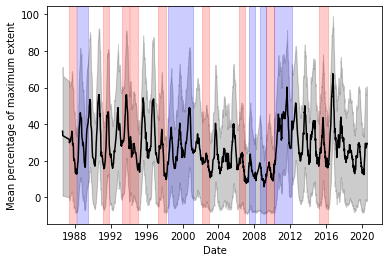

In [677]:
%matplotlib inline

mean = np.mean(history_matrix, axis=0)
std = np.std(history_matrix, axis=0)
plt.plot(dt_index, mean, c='black')
plt.fill_between(dt_index, mean - std, mean + std, color='black', alpha=0.2)
# for d in dt_index[dt_index.month == 1]:
#     plt.axvline(d, alpha=0.01, c='black')

def plot_la_nina_el_nino():
    for la_nina_from, la_nina_to in [('2010-04', '2012-03'), ('2008-08', '2009-04'), ('2007-06', '2008-02'), ('1998-05', '2001-03'), ('1988-04', '1989-07')]:
        plt.axvspan(np.datetime64(la_nina_from), np.datetime64(la_nina_to), color='blue', alpha=0.2)
    for el_nino_from, el_nino_to in [('2015-04', '2016-04'), ('2009-05', '2010-03'), ('2006-05', '2007-01'), ('2002-03', '2003-01'), ('1997-04', '1998-03'),
                                     ('1994-03', '1995-01'), ('1993-04', '1994-02'), ('1991-03', '1991-11'), ('1987-05', '1988-03')]:
        plt.axvspan(np.datetime64(el_nino_from), np.datetime64(el_nino_to), color='red', alpha=0.2)
plot_la_nina_el_nino()
    
plt.xlabel('Date')
plt.ylabel('Mean percentage of maximum extent')
# plt.xlim(np.datetime64('2008-01'), np.datetime64('2012-01'))

I've highlighted the dates in January in the dataset: these have lower water levels on average, which makes sense for the middle of summer in NSW and Victoria. I've also highlighted La Niña and El Niño events in blue and red respectively. They are weakly correlated with significant increases and decreases in mean water level. In particular, the very strong 2010-2012 La Niña corresponds with a particularly large increase in average water extent.

Next we'll do PCA.

In [623]:
pca = sklearn.decomposition.PCA(n_components=50)
pca_f = pca.fit_transform(history_matrix)

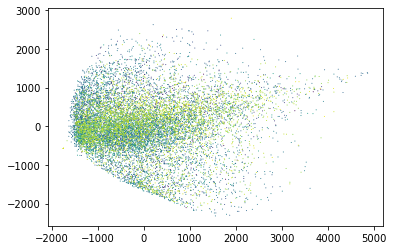

In [640]:
plt.scatter(pca_f[:, 0], pca_f[:, 1], s=1, edgecolor='None', c=waterbodies.FID)

There are no obvious correlations in 2-PCA-space. Let's try t-SNE.

In [641]:
import sklearn.manifold

In [643]:
tsne = sklearn.manifold.TSNE(verbose=True)

In [644]:
tsne_f = tsne.fit_transform(pca_f)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12535 samples in 0.203s...
[t-SNE] Computed neighbors for 12535 samples in 29.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12535
[t-SNE] Computed conditional probabilities for sample 2000 / 12535
[t-SNE] Computed conditional probabilities for sample 3000 / 12535
[t-SNE] Computed conditional probabilities for sample 4000 / 12535
[t-SNE] Computed conditional probabilities for sample 5000 / 12535
[t-SNE] Computed conditional probabilities for sample 6000 / 12535
[t-SNE] Computed conditional probabilities for sample 7000 / 12535
[t-SNE] Computed conditional probabilities for sample 8000 / 12535
[t-SNE] Computed conditional probabilities for sample 9000 / 12535
[t-SNE] Computed conditional probabilities for sample 10000 / 12535
[t-SNE] Computed conditional probabilities for sample 11000 / 12535
[t-SNE] Computed conditional probabilities for sample 12000 / 12535
[t-SNE] Computed conditional probabilities for sa

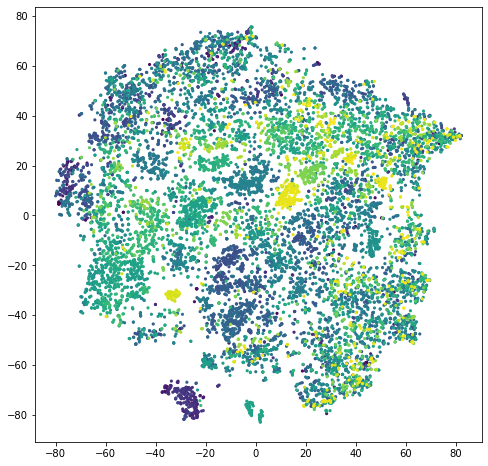

In [670]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], s=10, edgecolor='None', c=waterbodies.centroid.x)

This does have some obvious substructure, particularly when we colour it by position. Let's cluster it!

In [683]:
kmc = sklearn.cluster.KMeans(n_clusters=25)

In [686]:
clusters = kmc.fit_predict(tsne_f)

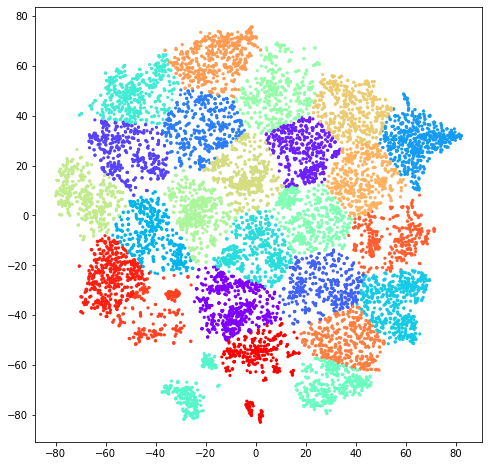

In [722]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], s=10, edgecolor='None', c=clusters, cmap='rainbow')

In [687]:
buffered = waterbodies.buffer(500)

In [736]:
waterbodies.drop(columns='water_history').to_file('waterbodies_murray.geojson', driver='GeoJSON')

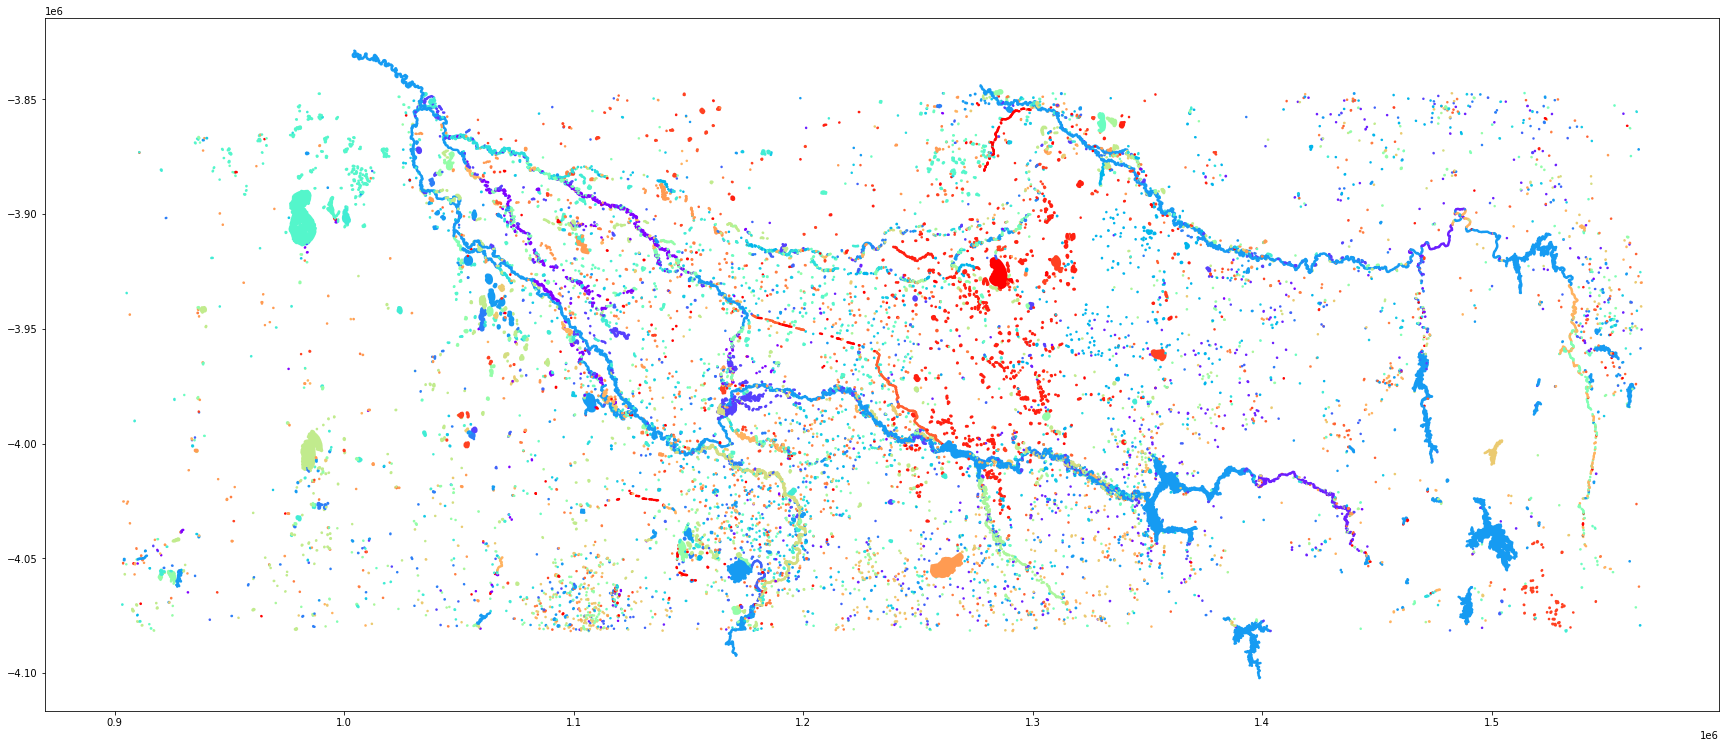

In [739]:
%matplotlib inline
ax = plt.figure(figsize=(30, 20)).add_subplot(1, 1, 1)
gpd.GeoDataFrame(geometry=buffered).plot(ax=ax, column=clusters, cmap='rainbow')

We pull out some major river and lake systems, but everything else seems fairly random. Let's try something else.

I'm gonna try following [this paper](https://www.hindawi.com/journals/tswj/2014/562194/) which makes a good point that shape-sensitive algorithms can be run on subsets that have first been clustered with simpler, time-ignorant methods. First we need to z-scale the data:

In [745]:
z_data = history_matrix - history_matrix.mean(axis=0, keepdims=True)
z_data /= z_data.std(axis=0, keepdims=True)

In [746]:
z_data.mean(axis=0)

array([-1.66231431e-15,  1.87794822e-14,  1.25339441e-14, ...,
        4.36200515e-15,  1.74843520e-16, -2.93232619e-16])

The paper mentioned above uses CAST, but there's no good implementation of this I can find. Anyway, it seems to be an aggregation-based hierarchical clustering algorithm (of which many exist), and there are plenty of others that fit the use case described in that paper. I did try DBSCAN, but of course as it's a density clusterer and we're in high dimension it didn't work terribly well. Instead I'll use an agglomerative clusterer with Ward linkage. Later we can try DBSCAN with PCA too. The only parameter we need to set is distance threshold, which is very similar to setting the number of clusters (higher threshold = less clusters). I've so far tried a distance threshold of 60, which lead to ~5700 clusters, which is computationally infeasible (and only really halves the size of our problem). Lots of these had very few elements:

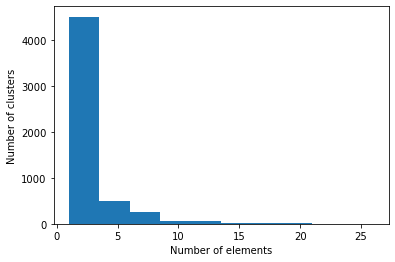

120 might be a better bet. This number will be related to the variance in the z-scaled data as well as the number of time channels.

In [749]:
# dists = scipy.spatial.distance.pdist(z_data)

In [759]:
np.percentile(dists, [5, 95])

array([ 61.97200244, 151.30828354])

In [835]:
agg = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=120)

In [836]:
agg_clusters = agg.fit_predict(z_data)

In [837]:
len(np.unique(agg_clusters))

701

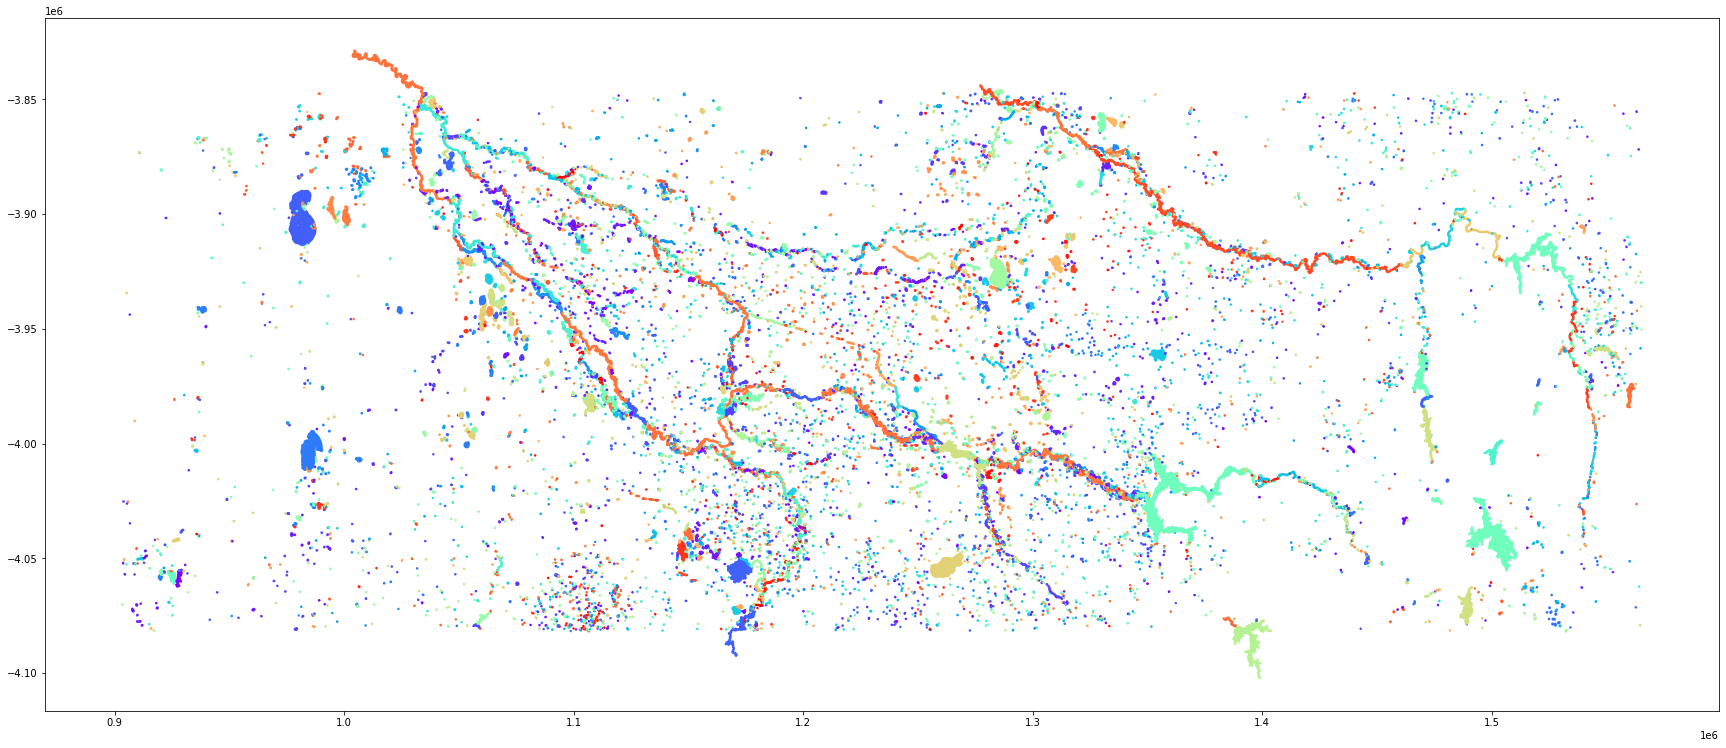

In [838]:
%matplotlib inline
ax = plt.figure(figsize=(30, 20)).add_subplot(1, 1, 1)
gpd.GeoDataFrame(geometry=buffered).plot(ax=ax, column=agg_clusters, cmap='rainbow')

How many members do each cluster have? This tells us roughly how meaningful the clusters are: If there is only one element in a cluster, that's not a very meaningful cluster. If there's too many, then it's also not meaningful.

In [839]:
count, _ = np.histogram(agg_clusters, bins=np.arange(agg.n_clusters_))

Text(0, 0.5, 'Number of clusters')

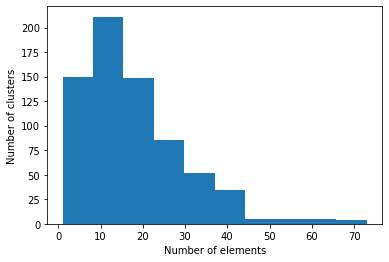

In [840]:
plt.hist(count)
plt.xlabel('Number of elements')
plt.ylabel('Number of clusters')

Let's have a look at a few of the biggest clusters.

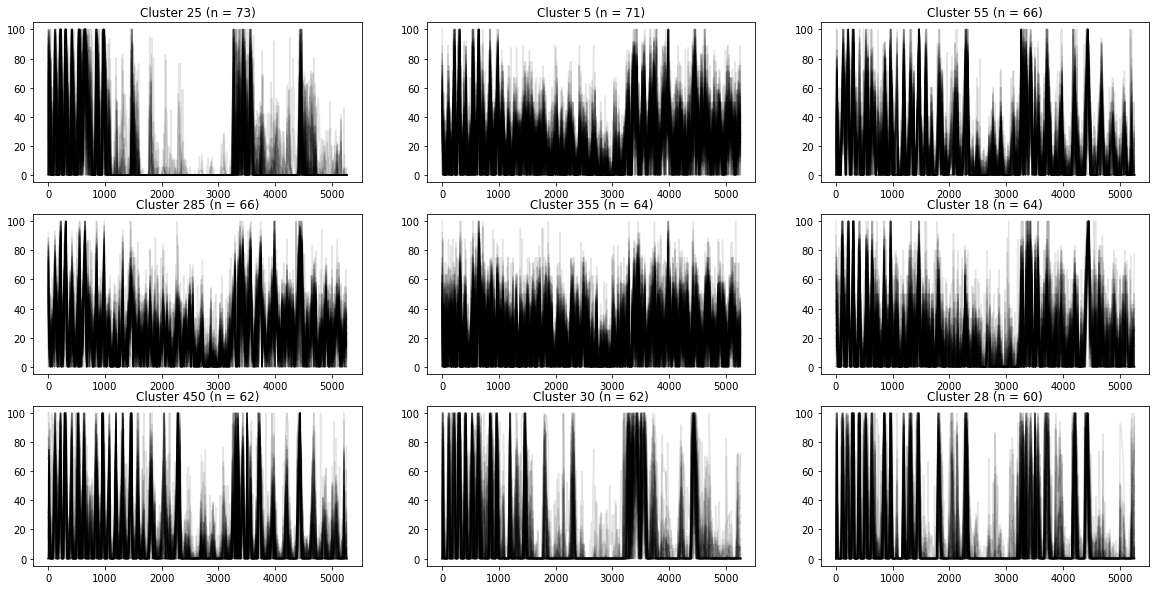

In [841]:
size_sort = np.argsort(count)[::-1]
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.plot(history_matrix[agg_clusters == size_sort[i]].T, c='k', alpha=0.1)
    n = sum(agg_clusters == size_sort[i])
    plt.title(f'Cluster {size_sort[i]} (n = {n})')

Let's see these on the map:

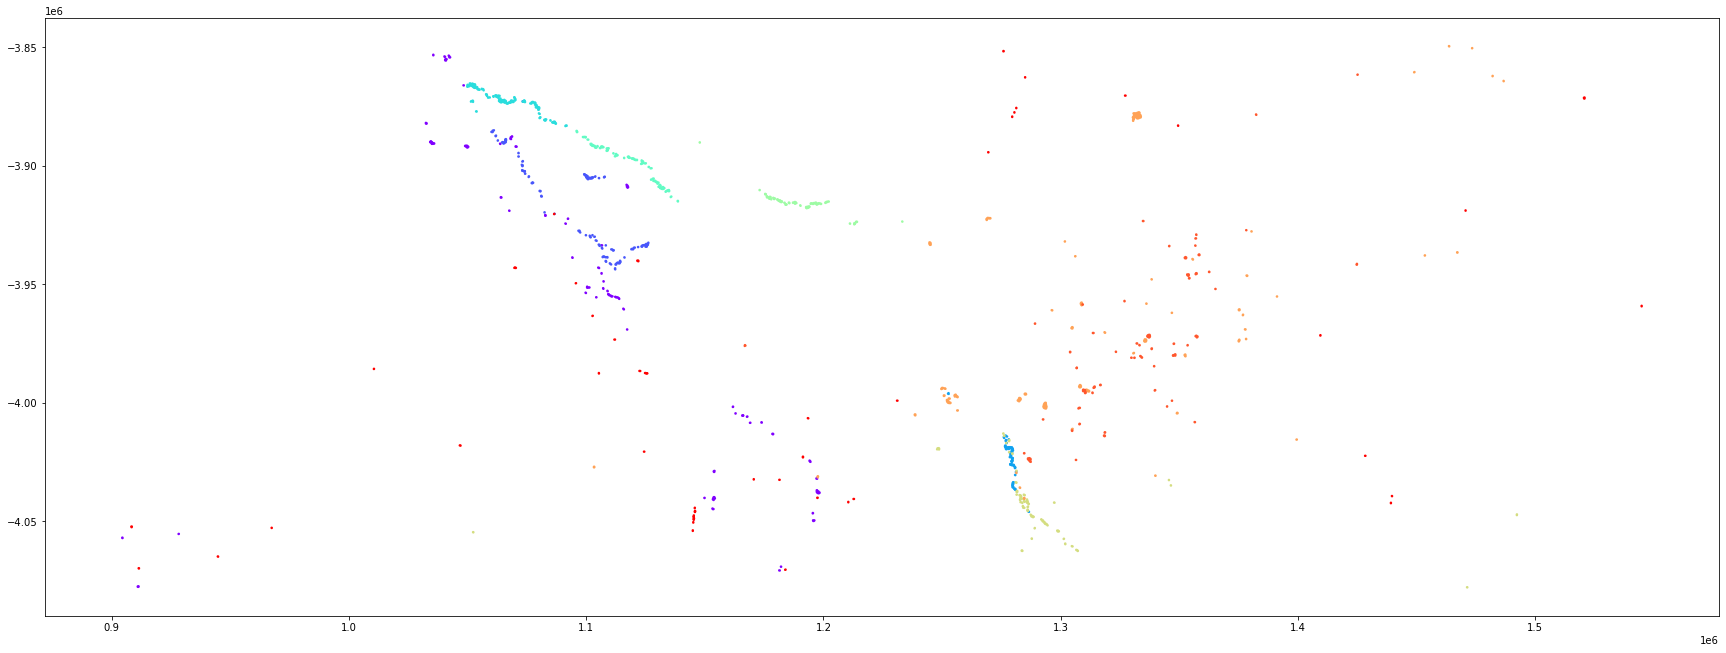

In [842]:
ax = plt.figure(figsize=(30, 20)).add_subplot(1, 1, 1)
colours = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    gpd.GeoDataFrame(geometry=buffered)[agg_clusters == size_sort[i]].plot(ax=ax, color=colours[i])

Next we need to create a prototype for each cluster. We'll take the mean time series for each cluster to represent that cluster - there are lots of other ways we could do this though.

In [843]:
prototypes = []
for c in tqdm(range(agg.n_clusters_)):
    prototypes.append(history_matrix[agg_clusters == c].mean(axis=0))

Now we can compute the dynamic time warping distance between each cluster. We'll subsample the time axis to try and speed this up, because it is impossibly slow otherwise.

In [846]:
zoom = 1 / 10
zoomed = scipy.ndimage.zoom(prototypes, (1, zoom))

In [848]:
assert len(zoomed) == agg.n_clusters_
zoomed.shape

(701, 526)

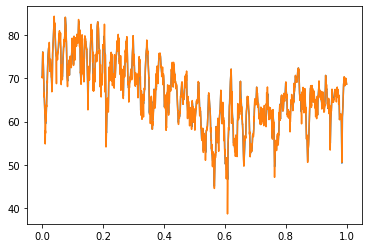

In [852]:
plt.plot(np.linspace(0, 1, len(zoomed[0])), zoomed[0])
plt.plot(np.linspace(0, 1, len(prototypes[0])), prototypes[0])

In [854]:
dtw_matrix = np.zeros((agg.n_clusters_, agg.n_clusters_))
for c1 in tqdm(range(agg.n_clusters_-1, -1, -1), position=0):
    for c2 in range(c1):
        dist = fastdtw(zoomed[c1], zoomed[c2])
        dtw_matrix[c1, c2] = dist[0]

In [860]:
sym_dtw_matrix = dtw_matrix.T + dtw_matrix

Now we can cluster using any clustering algorithm that supports a distance matrix. We'll use agglomerative clustering again and look for 5 clusters (entirely arbitrary).

In [916]:
agg2 = sklearn.cluster.AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=5)

In [917]:
agg2_clusters = agg2.fit_predict(sym_dtw_matrix)

In [918]:
clusters = agg2_clusters[agg_clusters]

In [919]:
np.unique(clusters)

array([0, 1, 2, 3, 4])

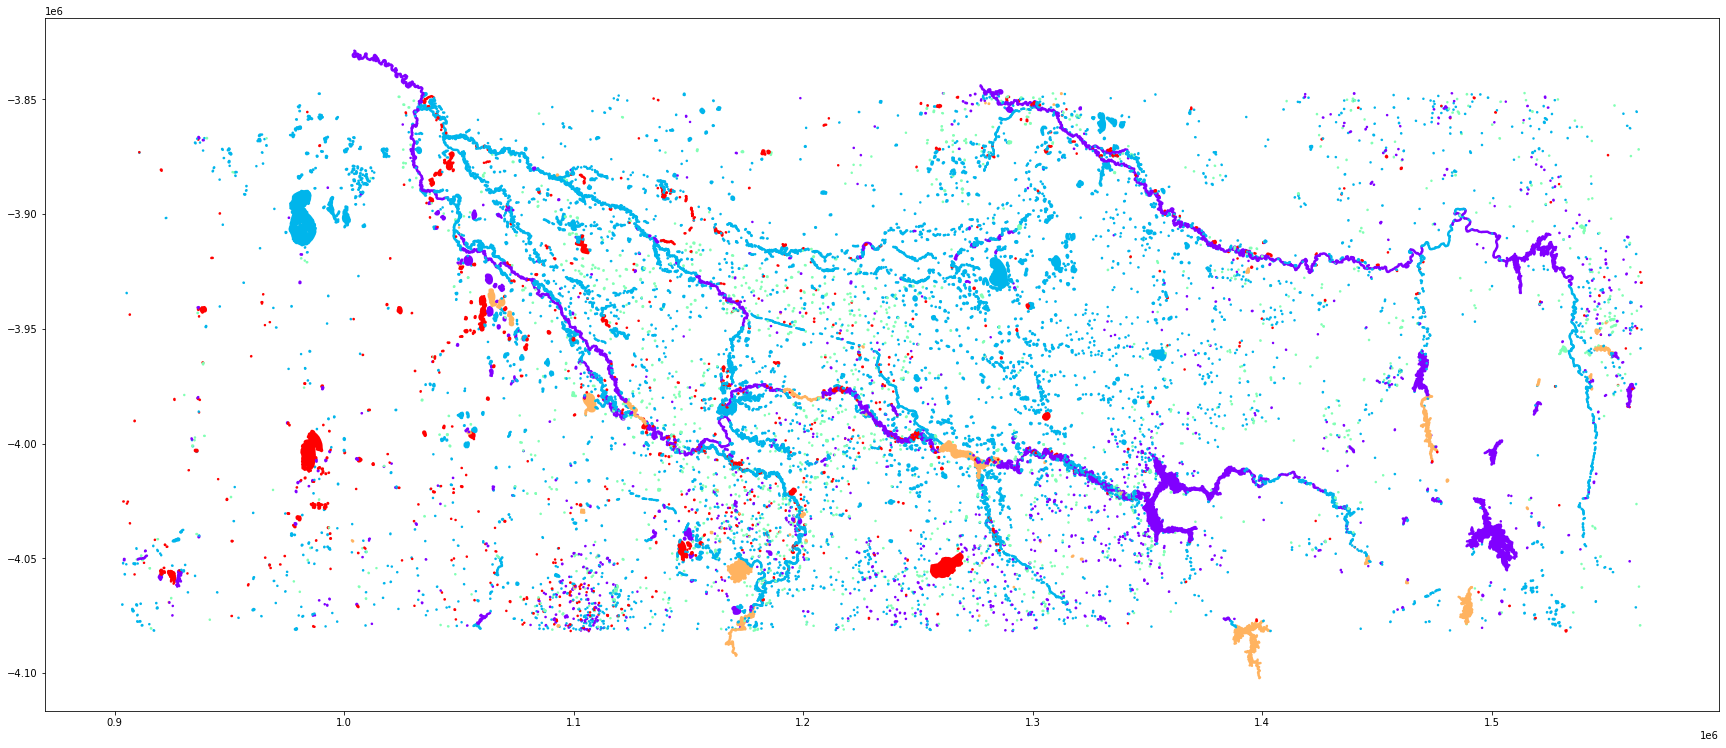

In [920]:
ax = plt.figure(figsize=(30, 20)).add_subplot(1, 1, 1)
gpd.GeoDataFrame(geometry=buffered).plot(ax=ax, column=clusters, cmap='rainbow')

Let's dump this to GeoJSON so we can look in QGIS.

In [922]:
waterbodies['cluster'] = clusters

In [928]:
waterbodies.drop(columns='water_history').to_file('waterbodies_murray.geojson', driver='GeoJSON')

It's fine? Not great though. I would really like the rivers to match. At least all of Canberra's main lakes are in the same cluster.